In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 100 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn
    
#     print(filename, length)
    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
#         print(start_time-1, end_time)
        if(end_time<=length):
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
all_train_data_list = []
#[4, 6, '2R', 'WC']
for i in range(1,7): #1,2,3,5,6,  7,8,  9, 10
    all_train_data_list.append([i, 1, '1L', 'WC'])
    all_train_data_list.append([i, 1, '2R', 'WC'])
    all_train_data_list.append([i, 2, '1L', 'WC'])
    all_train_data_list.append([i, 2, '2R', 'WC'])
    
    all_train_data_list.append([i, 3, '1L', 'WC'])
    all_train_data_list.append([i, 3, '2R', 'WC'])
    all_train_data_list.append([i, 5, '1L', 'WC'])
    all_train_data_list.append([i, 5, '2R', 'WC'])
    
    
    all_train_data_list.append([i, 6, '1L', 'WC'])
    all_train_data_list.append([i, 6, '2R', 'WC'])
    all_train_data_list.append([i, 7, '1L', 'WC'])
    all_train_data_list.append([i, 7, '2R', 'WC'])
#     all_data_list.append([i, 8, '1L', 'WC'])
#     all_data_list.append([i, 8, '2R', 'WC'])   

all_train_data_list.append([7, 9, '1L', 'WC'])
all_train_data_list.append([8, 9, '1L', 'WC'])
all_train_data_list.append([9, 10, '1L', 'WC'])
all_train_data_list.append([10, 10, '1L', 'WC'])                          

all_train_data_list.append([7, 9, '2R', 'WC'])
all_train_data_list.append([8, 9, '2R', 'WC'])
all_train_data_list.append([9, 10, '2R', 'WC'])
all_train_data_list.append([10, 10, '2R', 'WC'])

all_train_data_list.remove([4, 6, '2R', 'WC'])
print(all_train_data_list)

[[1, 1, '1L', 'WC'], [1, 1, '2R', 'WC'], [1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [1, 3, '1L', 'WC'], [1, 3, '2R', 'WC'], [1, 5, '1L', 'WC'], [1, 5, '2R', 'WC'], [1, 6, '1L', 'WC'], [1, 6, '2R', 'WC'], [1, 7, '1L', 'WC'], [1, 7, '2R', 'WC'], [2, 1, '1L', 'WC'], [2, 1, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [2, 3, '1L', 'WC'], [2, 3, '2R', 'WC'], [2, 5, '1L', 'WC'], [2, 5, '2R', 'WC'], [2, 6, '1L', 'WC'], [2, 6, '2R', 'WC'], [2, 7, '1L', 'WC'], [2, 7, '2R', 'WC'], [3, 1, '1L', 'WC'], [3, 1, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [3, 3, '1L', 'WC'], [3, 3, '2R', 'WC'], [3, 5, '1L', 'WC'], [3, 5, '2R', 'WC'], [3, 6, '1L', 'WC'], [3, 6, '2R', 'WC'], [3, 7, '1L', 'WC'], [3, 7, '2R', 'WC'], [4, 1, '1L', 'WC'], [4, 1, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [4, 3, '1L', 'WC'], [4, 3, '2R', 'WC'], [4, 5, '1L', 'WC'], [4, 5, '2R', 'WC'], [4, 6, '1L', 'WC'], [4, 7, '1L', 'WC'], [4, 7, '2R', 'WC'], [5, 1, '1L', 'WC'], [5, 1, '2R', 'WC'], [5, 2, '1L', 'WC'],

In [5]:
step_train_data_list = []
step_valid_data_list = []
for i in range(1, 8):
    if(i==4):
        continue
    step_train_data_list_part = [j for j in all_train_data_list if j[1]!=i]
    step_valid_data_list_part = [j for j in all_train_data_list if j[1]==i]
    print(len(step_train_data_list_part))
    print(step_train_data_list_part)
    print('-----')
    print(len(step_valid_data_list_part))
    print(step_valid_data_list_part)
    print('=====')
    step_train_data_list.append(step_train_data_list_part)
    step_valid_data_list.append(step_valid_data_list_part)
    
    

67
[[1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [1, 3, '1L', 'WC'], [1, 3, '2R', 'WC'], [1, 5, '1L', 'WC'], [1, 5, '2R', 'WC'], [1, 6, '1L', 'WC'], [1, 6, '2R', 'WC'], [1, 7, '1L', 'WC'], [1, 7, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [2, 3, '1L', 'WC'], [2, 3, '2R', 'WC'], [2, 5, '1L', 'WC'], [2, 5, '2R', 'WC'], [2, 6, '1L', 'WC'], [2, 6, '2R', 'WC'], [2, 7, '1L', 'WC'], [2, 7, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [3, 3, '1L', 'WC'], [3, 3, '2R', 'WC'], [3, 5, '1L', 'WC'], [3, 5, '2R', 'WC'], [3, 6, '1L', 'WC'], [3, 6, '2R', 'WC'], [3, 7, '1L', 'WC'], [3, 7, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [4, 3, '1L', 'WC'], [4, 3, '2R', 'WC'], [4, 5, '1L', 'WC'], [4, 5, '2R', 'WC'], [4, 6, '1L', 'WC'], [4, 7, '1L', 'WC'], [4, 7, '2R', 'WC'], [5, 2, '1L', 'WC'], [5, 2, '2R', 'WC'], [5, 3, '1L', 'WC'], [5, 3, '2R', 'WC'], [5, 5, '1L', 'WC'], [5, 5, '2R', 'WC'], [5, 6, '1L', 'WC'], [5, 6, '2R', 'WC'], [5, 7, '1L', 'WC'], [5, 7, '2R', 'WC'], [6, 2, '1L', 'WC

In [6]:
batch_size = 256
train_x_list, train_y_list = [], []
print(batch_size)

for step_train_data in step_train_data_list:
    data_x, data_y = [], []
    
    for i in step_train_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        for dx in data_x_segement:
            data_x.extend(dx)
        for dy in data_y_segement:
            data_y.extend(dy)
    
    print(len(data_x))
#     print(len(data_y))
    
    order = list(range(0,len(data_x),1))
    random.shuffle(order)

    train_x = [data_x[i] for i in order]
#     train_x.extend([i for i in train_x[:batch_size]])
    train_x.extend([train_x[i] for i in range(0, batch_size)])
    train_y = [data_y[i] for i in order]
#     train_y.extend([i for i in train_y[:batch_size]])
    train_y.extend([train_y[i] for i in range(0, batch_size)])

    print(len(train_x))
    
    train_x_list.append(train_x)
    train_y_list.append(train_y)

256
159276
159532
159518
159774
163468
163724
163908
164164
169400
169656
164080
164336


In [7]:
valid_x_list, valid_y_list = [], []

for step_valid_data in step_valid_data_list:
    valid_x, valid_y=[], []
    for i in step_valid_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        valid_x.extend(data_x_segement)
        valid_y.extend(data_y_segement)
    
    print(len(valid_x))
#     print(len(valid_y))
    
    valid_x_list.append(valid_x)
    valid_y_list.append(valid_y)

72
68
68
72
54
60


In [8]:
step_test_list = []
for i in range(1,7):
    step_test_list.append([i, 8, '1L', 'WC'])
    step_test_list.append([i, 8, '2R', 'WC'])  
      
print(step_test_list)

[[1, 8, '1L', 'WC'], [1, 8, '2R', 'WC'], [2, 8, '1L', 'WC'], [2, 8, '2R', 'WC'], [3, 8, '1L', 'WC'], [3, 8, '2R', 'WC'], [4, 8, '1L', 'WC'], [4, 8, '2R', 'WC'], [5, 8, '1L', 'WC'], [5, 8, '2R', 'WC'], [6, 8, '1L', 'WC'], [6, 8, '2R', 'WC']]


In [9]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

60
60
[63, 199, 890, 43, 63, 199, 890, 43, 50, 1320, 110, 26, 50, 1320, 110, 26, 1687, 324, 1687, 324, 361, 1597, 250, 1216, 330, 869, 109, 812, 361, 1597, 250, 1216, 330, 869, 109, 812, 91, 342, 791, 274, 154, 161, 302, 467, 332, 211, 91, 342, 791, 274, 154, 161, 302, 467, 332, 211, 778, 1355, 778, 1355]


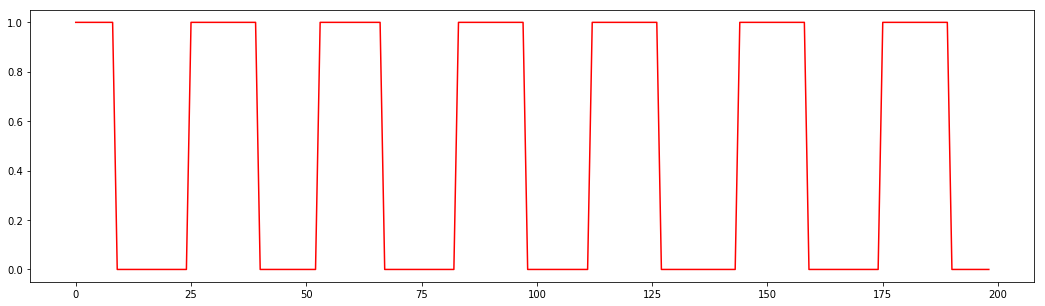

In [10]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [11]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

(?, 100, 1)
(100, 1)


In [12]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [13]:
print(len(train_x_list))
print(len(train_x_list[0]))
print(len(train_x_list[0][0]))
print(len(train_x_list[0][0][0]))
# print(train_x_list[0][0].shape)
batch_start = 0

6
159532
100
6


In [14]:
training_steps = 4001
valid_loss_list, valid_logits_list = [], []
test_loss_list, test_logits_list = [], []

for i in range(0, 6):
    batch_start=0
    print("cross validation ", i)
#     batch_start = 0
    train_x = train_x_list[i]
    train_y = train_y_list[i]
    train_length = len(train_x_list[i])-256
    valid_x = valid_x_list[i]
    valid_y = valid_y_list[i]
    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(graph=graph, config=config) as session:
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#         saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-1.ckpt-6000")
        tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(training_steps):      
            feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
            _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
            if (step % 200 == 0):
                train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
                print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
                #train accuarcy
            if (step % 1000 == 0):
                saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-'+str(i)+'.ckpt', global_step=step)
            batch_start += batch_size
            if(batch_start>=train_length):
                batch_start -=train_length
        valid_loss, valid_logits = [], []
        for j in range(len(valid_x)):
            valid_loss_part, valid_logits_part = session.run([loss,logits], feed_dict={X: valid_x[j], Y: valid_y[j]})
            valid_loss.append(valid_loss_part)
            valid_logits.append(valid_logits_part)

        valid_loss_list.append(valid_loss)
        valid_logits_list.append(valid_logits)

        test_loss, test_logits = [], []
        for j in range(len(test_x)):
            test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[j], Y: test_y[j]})
            test_loss.append(test_loss_part)
            test_logits.append(test_logits_part)

        test_loss_list.append(test_loss)
        test_logits_list.append(test_logits)

cross validation  0
Initialized
Loss at step 0: 0.513654, train accuarcy : 0.450704
Loss at step 200: 0.146381, train accuarcy : 0.839437
Loss at step 400: 0.120540, train accuarcy : 0.870423
Loss at step 600: 0.108501, train accuarcy : 0.864789
Loss at step 800: 0.097840, train accuarcy : 0.912676
Loss at step 1000: 0.095374, train accuarcy : 0.884507
Loss at step 1200: 0.088773, train accuarcy : 0.901408
Loss at step 1400: 0.082771, train accuarcy : 0.909859
Loss at step 1600: 0.084974, train accuarcy : 0.895775
Loss at step 1800: 0.072230, train accuarcy : 0.935211
Loss at step 2000: 0.072235, train accuarcy : 0.926761
Loss at step 2200: 0.076992, train accuarcy : 0.946479
Loss at step 2400: 0.071458, train accuarcy : 0.923944
Loss at step 2600: 0.068018, train accuarcy : 0.915493
Loss at step 2800: 0.069148, train accuarcy : 0.949296
Loss at step 3000: 0.066275, train accuarcy : 0.918310
Loss at step 3200: 0.062641, train accuarcy : 0.923944
Loss at step 3400: 0.062914, train accua

# valid

54
72


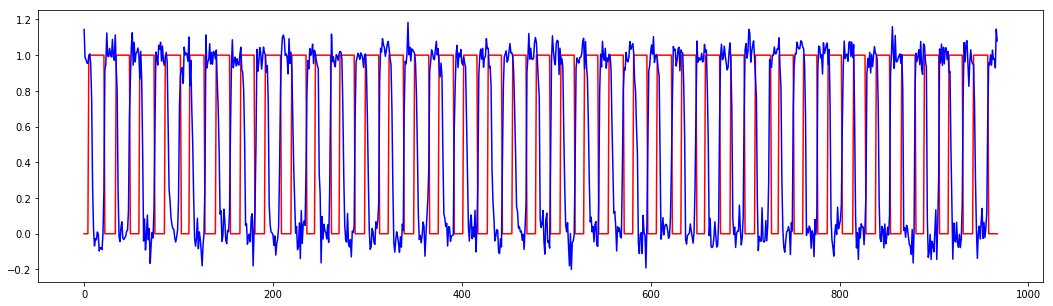

In [79]:
print(len(valid_y))
print(len(valid_logits_list[0]))

# index=1

valid_logits = valid_logits_list[index]
valid_y = valid_y_list[index]


plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[-1][0] for i in valid_y[index1][start:end]], 'r')
plt.plot([i[-1][0] for i in valid_logits[index1][start:end]], 'b')
plt.show()

In [80]:
print(len(test_logits_list), len(test_logits_list[0]), len(test_logits_list[0][0]), len(test_logits_list[0][0][0]))
print(0, len(test_y), len(test_y[0]), len(test_y[0][0]))

6 60 63 100
0 60 63 100


In [81]:
# index=1
print(len(valid_logits_list), len(valid_logits_list[index]), len(valid_logits_list[index][0]), len(valid_logits_list[index][0][0]))
print(len(valid_y_list), len(valid_y_list[index]), len(valid_y_list[index][0]), len(valid_y_list[index][0][0]))

6 60 70 100
6 60 70 100


In [82]:
print(len(valid_logits), len(valid_logits[0]), len(valid_logits[0][0]))


print(len(valid_y))
print(len(valid_y[0]))
print(len(valid_y[0][0]))  

valid_y_seq_list, valid_logits_bin_list = [], []

for t in valid_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    valid_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(valid_logits_part)-1):
        if(valid_logits_part[i-1][0]!=valid_logits_part[i][0] and valid_logits_part[i-1][0]==valid_logits_part[i+1][0]):
            valid_logits_part[i][0]=valid_logits_part[i-1][0]  
    
    valid_logits_bin_list.append(valid_logits_part)
    
for t in valid_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    valid_y_seq_list.append(t_all)

# print(valid_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(valid_y_seq_list)):
    total += len(valid_y_seq_list[i])
#     print(len(valid_y_seq_list[i]), len(valid_logits_bin_list[i]))
    
    for j in range(0, len(valid_y_seq_list[i])):
        if(valid_y_seq_list[i][j][0] == valid_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("valid accuarcy : ", count*1.0/total)

60 70 100
60
70
100
15622
33654
valid accuarcy :  0.46419444939680277


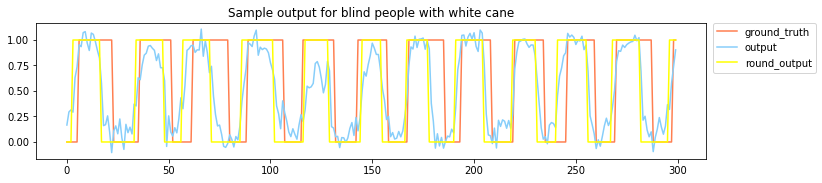

In [102]:

start=0
end=300
plt.figure(figsize=(12, 2.5))
plt.title('Sample output for blind people with white cane')
plt.plot([i[-1][0] for i in valid_y[index1][start:end]], 'coral', label='ground_truth')
plt.plot([i[-1][0] for i in valid_logits[index1][start:end]], 'lightskyblue', label='output')
plt.plot([i[0] for i in valid_logits_bin_list[index1][timesteps:][start:end]], 'yellow', label='round_output')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# plt.plot([round(i[-1][0]) for i in test_logits[index]], 'b')
plt.show()

In [84]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#valid_y_seq_list, valid_logits_bin_list
for i in range(0, len(valid_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(valid_y_seq_list[i])):
        if(abs(valid_y_seq_list[i][j][0]-valid_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(valid_logits[i][0]-valid_logits[i-1][0])>0.5):
        if(abs(valid_logits_bin_list[i][j][0]-valid_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
#     step_time_predict.append(step_time_predict_part)

    average_time = (step_time_predict_part[-1]-step_time_predict_part[0])/(len(step_time_predict_part)-1)
    step_time_predict_part_1 = [step_time_predict_part[0]]
#     for i in range(1, len(step_time_predict_part)):
#         if(step_time_predict_part[i]-step_time_predict_part_1[-1]>average_time/2):
#             step_time_predict_part_1.append(step_time_predict_part[i])
    j = 1
    while j<len(step_time_predict_part):
        if(step_time_predict_part[j]-step_time_predict_part_1[-1]>average_time/4):
            step_time_predict_part_1.append(step_time_predict_part[j])
            j += 1
        else:
            j += 2
            
#     print(step_time_predict_part)
#     print(step_time_predict_part_1) 
    
    step_time_predict.append(step_time_predict_part_1)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[12, 14, 81, 13, 12, 14, 81, 13, 14, 114, 17, 8, 14, 114, 17, 8, 109, 33, 109, 33, 26, 93, 13, 97, 13, 73, 14, 74, 26, 93, 13, 97, 13, 73, 14, 74, 7, 37, 59, 31, 42, 32, 110, 7, 37, 59, 31, 42, 32, 110, 51, 45, 45, 12, 7, 51, 45, 45, 12, 7]
[14, 15, 90, 13, 11, 15, 81, 10, 17, 112, 22, 8, 15, 113, 16, 8, 115, 32, 111, 33, 30, 92, 12, 94, 15, 66, 15, 77, 28, 92, 11, 97, 13, 73, 14, 73, 8, 42, 63, 39, 43, 32, 112, 10, 38, 60, 32, 41, 31, 111, 55, 48, 46, 11, 7, 51, 44, 44, 11, 7]
[12, 23, 41, 53, 68, 79, 96, 105, 122, 135, 151, 161, 179, 188, 206, 215, 231, 242, 257, 267, 285, 293, 308, 319, 334, 345, 359, 369, 387, 397, 412, 423, 438, 448, 464, 474, 490, 500, 515, 524, 542, 551, 566, 576, 592, 602, 617, 626, 642, 653, 667, 678, 694, 705, 720, 731, 746, 757, 772, 782, 797, 808, 823, 833, 850, 860, 876, 886, 902, 911, 927, 937, 952, 962, 979, 987, 1002, 1013, 1029, 1038, 1055, 1064, 1080, 1090, 1106, 1116, 1133, 1142, 1159, 1169, 1184, 1195, 1210, 1221, 1236,

In [85]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(valid_y))

for i in range(len(valid_y)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

60
60
153
[2, 1, 10, 0, 1, 1, 0, 1, 3, 3, 7, 1, 1, 0, 0, 0, 8, 1, 2, 1, 4, 0, 1, 7, 2, 7, 3, 10, 2, 1, 0, 0, 0, 0, 0, 0, 2, 9, 5, 13, 3, 1, 12, 3, 1, 1, 2, 0, 1, 2, 7, 6, 4, 0, 1, 0, 0, 0, 0, 0]
60
78
[2, 1, 9, 0, 0, 1, 0, 0, 3, 0, 5, 0, 1, 0, 0, 0, 6, 0, 2, 0, 4, 0, 0, 0, 2, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 1, 5, 4, 8, 1, 0, 2, 3, 1, 1, 1, 0, 0, 1, 4, 3, 1, 0, 0, 0, 0, 0, 0, 0]
error : 
total undercount metric 1:	 0.13348765432098766
total overcount metric 1:	 0.13695987654320987
total undercount metric 2:	 0.04089506172839506
total overcount metric 2:	 0.059027777777777776
total undercount metric 3:	 0.011959876543209876
total overcount metric 3:	 0.03009259259259259


# test

In [132]:
print("test loss : ", test_loss)

test loss :  [0.55861306, 0.52461058, 0.50766248, 0.57678735, 0.29939947, 0.39504942, 0.42487922, 0.39760515, 0.67796856, 0.53905398, 0.60230625, 0.64264953, 0.34345907, 0.38790062, 0.32213664, 0.31385273, 0.5891732, 0.63407439, 0.3836717, 0.41033855, 0.6232928, 0.57793927, 0.41525641, 0.57042885, 0.48956442, 0.62363571, 0.62354702, 0.61150467, 0.36111578, 0.35319191, 0.34382769, 0.41796941, 0.32272792, 0.3953667, 0.3225638, 0.42704865, 0.67200917, 0.62885314, 0.46214834, 0.58796507, 0.55295265, 0.44323376, 0.55196524, 0.58333892, 0.55189967, 0.64194709, 0.36072168, 0.41023844, 0.4395954, 0.42123687, 0.41029045, 0.45567611, 0.48243687, 0.46910423, 0.43812937, 0.4529568, 0.56019992, 0.48116058, 0.39164004, 0.44114074]


60
60


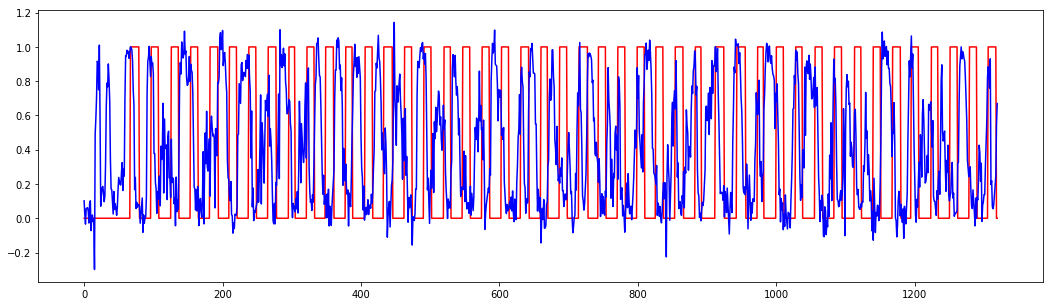

In [100]:
print(len(test_y))
print(len(test_logits_list[0]))

index = 5
index1= 9

test_logits = test_logits_list[index]


plt.figure(figsize=(18, 5))
start=0
end=2000
plt.plot([i[-1][0] for i in test_y[index1][start:end]], 'r')
plt.plot([i[-1][0] for i in test_logits[index1][start:end]], 'b')
plt.show()

In [76]:
print(len(test_logits))
print(len(test_logits[0]))
print(len(test_logits[0][0]))  

test_y_seq_list, test_logits_bin_list = [], []

for t in test_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    test_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin_list.append(test_logits_part)
    
for t in test_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    test_y_seq_list.append(t_all)

# print(test_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(test_y_seq_list)):
    total += len(test_y_seq_list[i])
    for j in range(0, len(test_y_seq_list[i])):
        if(test_y_seq_list[i][j][0] == test_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

60
63
100
16490
36968
test accuarcy :  0.4460614585587535


In [77]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#test_y_seq_list, test_logits_bin_list
for i in range(0, len(test_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(test_y_seq_list[i])):
        if(abs(test_y_seq_list[i][j][0]-test_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin_list[i][j][0]-test_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
#     step_time_predict.append(step_time_predict_part)

    average_time = (step_time_predict_part[-1]-step_time_predict_part[0])/(len(step_time_predict_part)-1)
    step_time_predict_part_1 = [step_time_predict_part[0]]
#     for i in range(1, len(step_time_predict_part)):
#         if(step_time_predict_part[i]-step_time_predict_part_1[-1]>average_time/2):
#             step_time_predict_part_1.append(step_time_predict_part[i])
    j = 1
    while j<len(step_time_predict_part):
        if(step_time_predict_part[j]-step_time_predict_part_1[-1]>average_time/4):
            step_time_predict_part_1.append(step_time_predict_part[j])
            j += 1
        else:
            j += 2
            
#     print(step_time_predict_part)
#     print(step_time_predict_part_1) 
    
    step_time_predict.append(step_time_predict_part_1)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[11, 20, 70, 9, 11, 20, 70, 9, 10, 95, 14, 7, 10, 95, 14, 7, 112, 28, 112, 28, 31, 104, 19, 93, 19, 68, 13, 64, 31, 104, 19, 93, 19, 68, 13, 64, 12, 33, 55, 26, 16, 19, 27, 40, 29, 22, 12, 33, 55, 26, 16, 19, 27, 40, 29, 22, 57, 96, 57, 96]
[11, 19, 61, 10, 11, 20, 71, 10, 11, 98, 13, 8, 9, 103, 16, 9, 122, 28, 122, 38, 31, 115, 22, 89, 22, 61, 12, 59, 37, 115, 23, 94, 32, 71, 16, 67, 14, 35, 64, 29, 17, 19, 27, 43, 30, 25, 13, 33, 72, 33, 28, 34, 31, 43, 38, 34, 57, 108, 67, 115]
[6, 24, 35, 52, 70, 166, 179, 196, 207, 225, 236, 253, 264, 281, 293, 309, 320, 337, 348, 365, 377, 395, 404, 421, 432, 448, 460, 477, 487, 505, 516, 532, 545, 562, 573, 590, 601, 619, 629, 646, 657, 674, 685, 702, 713, 730, 742, 759, 769, 786, 797, 814, 827, 842, 853, 870, 881, 898, 909, 925, 936, 953, 965, 982, 991, 1011, 1024, 1042, 1055, 1072, 1081, 1099, 1110, 1127, 1137, 1155, 1166, 1183, 1194, 1212, 1222, 1239, 1250, 1267, 1279, 1294, 1305, 1323, 1333, 1350, 1361, 1378, 13

In [78]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(test_x))

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

60
60
555
[3, 3, 11, 2, 1, 2, 16, 1, 1, 25, 2, 1, 0, 24, 3, 2, 28, 5, 15, 10, 5, 35, 6, 27, 8, 13, 1, 13, 7, 20, 5, 10, 15, 12, 3, 8, 2, 4, 14, 5, 4, 1, 5, 6, 4, 3, 2, 2, 20, 8, 13, 15, 5, 8, 12, 12, 5, 18, 11, 33]
60
256
[0, 0, 0, 1, 0, 0, 1, 1, 1, 3, 0, 1, 0, 8, 2, 2, 10, 0, 10, 10, 0, 11, 3, 0, 3, 0, 0, 0, 6, 11, 4, 1, 13, 3, 3, 3, 2, 2, 9, 3, 1, 0, 0, 3, 1, 3, 1, 0, 17, 7, 12, 15, 4, 3, 9, 12, 0, 12, 10, 19]
error : 
total undercount metric 1:	 0.14561115668580804
total overcount metric 1:	 0.21944216570959804
total undercount metric 2:	 0.13453650533223954
total overcount metric 2:	 0.2276456111566858
total undercount metric 3:	 0.011894995898277276
total overcount metric 3:	 0.10500410172272355
